# Log and Outputs Dir Config 

#### DONT CHANGE

In [2]:
import logging
import os
import sys
import pandas as pd
import numpy as np
import optuna
from forecasting_pipeline import forecast_pipeline_debug, add_hist_range
import importlib
import forecasting_pipeline
importlib.reload(forecasting_pipeline)
from forecasting_pipeline import forecast_pipeline_debug

class SuppressFilter(logging.Filter):
    def __init__(self, name=''):
        super().__init__(name)

    def filter(self, record):
        return not record.name.startswith(self.name)

Importing plotly failed. Interactive plots will not work.


## Set the current Notebook Path and Experiment Number

#### CHANGE

In [3]:

# --- CONFIGURATION (Stays in the notebook) ---
notebook_path ='.' # <- Outputs would be saved here #c2avi
os.chdir(notebook_path)
print(f"Current working directory: {os.getcwd()}")

EXPERIMENT_NUMBER = "Test02" # <- Change this for each experiment

Current working directory: c:\Users\aksha\FastAPI


#### DONT CHANGE

In [4]:
# --- Step 2: Define the log file name and path ---
log_filename = f'exp_{EXPERIMENT_NUMBER}_pipeline.log'
log_file_path = os.path.join(notebook_path, log_filename)

# --- Step 3: Configure the logger ---
logger = logging.getLogger()
if logger.hasHandlers():
    logger.handlers.clear()

logger.setLevel(logging.INFO)
log_file = open(log_file_path, 'w', buffering=1)

# Create file and console handlers
file_handler = logging.StreamHandler(log_file)
file_handler.setLevel(logging.INFO)
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)

# Create and apply the formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Step 2: Create an instance of our filter for 'cmdstanpy'
suppress_cmdstanpy_filter = SuppressFilter('cmdstanpy')
suppress_prophet_filter = SuppressFilter('prophet') 
# Step 3: Add the filter to the handlers
# This will stop 'cmdstanpy' logs from reaching both the file and the console output
file_handler.addFilter(suppress_cmdstanpy_filter)
console_handler.addFilter(suppress_cmdstanpy_filter)
file_handler.addFilter(suppress_prophet_filter) #<-- ADD THIS LINE
console_handler.addFilter(suppress_prophet_filter) #<-- ADD THIS LINE


# Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

logger.info(f"Logging configured. Log file: {log_file_path}")

2025-10-14 18:55:47 - INFO - Logging configured. Log file: .\exp_Test02_pipeline.log


# Data Loading

In [5]:
df_data = pd.read_csv("/Users/aksha/FastAPI/Data/Anonymized_PB-full.csv") #c1avi

In [8]:
df_data.dtypes

date         datetime64[ns]
Channel              object
Chain                object
Depot                object
SubCat               object
SKU                  object
UnitsSold           float64
dtype: object

### Ensure Date column is named 'date'

In [7]:
df_data.rename(columns={"Date": "date"}, inplace=True) # Rename the data's date column to lowercase 'date'
df_data["date"]=pd.to_datetime(df_data["date"] , dayfirst=True)  # Rename the data's date column to lowercase 'date'

C:\Users\aksha\AppData\Local\Temp\ipykernel_2472\2284722544.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_data["date"]=pd.to_datetime(df_data["date"] , dayfirst=True)  # Rename the data's date column to lowercase 'date'


In [9]:
df_data["date"].unique()

<DatetimeArray>
['2022-01-01 00:00:00', '2022-02-01 00:00:00', '2022-03-01 00:00:00',
 '2022-04-01 00:00:00', '2022-05-01 00:00:00', '2022-06-01 00:00:00',
 '2022-07-01 00:00:00', '2022-08-01 00:00:00', '2022-09-01 00:00:00',
 '2022-10-01 00:00:00', '2022-11-01 00:00:00', '2022-12-01 00:00:00',
 '2023-01-01 00:00:00', '2023-02-01 00:00:00', '2023-03-01 00:00:00',
 '2023-04-01 00:00:00', '2023-05-01 00:00:00', '2023-06-01 00:00:00',
 '2023-07-01 00:00:00', '2023-08-01 00:00:00', '2023-09-01 00:00:00',
 '2023-10-01 00:00:00', '2023-11-01 00:00:00', '2023-12-01 00:00:00',
 '2024-01-01 00:00:00', '2024-02-01 00:00:00', '2024-03-01 00:00:00',
 '2024-04-01 00:00:00', '2024-05-01 00:00:00', '2024-06-01 00:00:00',
 '2024-07-01 00:00:00', '2024-08-01 00:00:00', '2024-09-01 00:00:00',
 '2024-10-01 00:00:00', '2024-11-01 00:00:00', '2024-12-01 00:00:00']
Length: 36, dtype: datetime64[ns]

In [10]:
df_data["date"].dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Main Config: 

#### CHANGE

#### Key Hierarchy and Target Variable

In [11]:
# EDIT THESE AS PER DATA
KEY_COLS = ['Channel','Chain','Depot','SubCat','SKU'] #Optional, can use predefined key col also
TARGET_COL = 'UnitsSold'

# DONT CHANGE THESE (DATE_COL and key_col)
DATE_COL = 'date'
key_col = 'key'

In [12]:
# DONT CHANGE THESE
DATE_COL = 'date'
key_col = 'key'

### - Creating key
### - Creating Product Mapping
### - Cleaning Duplicates
### - Adding Historical Range values for each key
### - Formatting dtypes for input dataframe

#### DONT CHANGE (IDEALLY)

In [13]:
# Nothing to change here as such
joiner = lambda x:'_'.join(map(str,x))
df_data[key_col]=df_data[KEY_COLS].apply(joiner,axis=1)
df_data['key'] = df_data['key'].astype(str)

product_mapping = df_data[['key'] + KEY_COLS].drop_duplicates().reset_index(drop=True)

df = df_data[[key_col, DATE_COL, TARGET_COL]].copy()

df.groupby([key_col, DATE_COL])[TARGET_COL].sum().reset_index()

df = add_hist_range(df, key_col=key_col, date_col=DATE_COL)

#df[DATE_COL] = pd.to_datetime(df[DATE_COL]) #avi3
df[DATE_COL] = pd.to_datetime(df[DATE_COL], format='mixed', dayfirst=False)
df[key_col] = df[key_col].astype(str)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')

### Define key-wise Seasonality, each key must have either a 'Y' or 'N' value

#### CHANGE

In [14]:
# Assign random 'Y' or 'N' to each unique key  
np.random.seed(42)  # For reproducibility
key_to_seasonal = {k: np.random.choice(['Y', 'N']) for k in df['key'].unique()}
# Map to the dataframe
df['seasonal'] = df['key'].map(key_to_seasonal)

In [15]:
df

,key,date,UnitsSold,hist_range,seasonal
0,Retail_ValueStore_West Depot_Personal Care_PRD...,2022-01-01,1008.0,36+,Y
1,Online_FreshMart_North Depot_Snacks_PRD0006,2022-01-01,1035.0,25–36,N
2,Retail_FoodBazaar_South Depot_Frozen Foods_PRD...,2022-01-01,1035.0,25–36,Y
3,Retail_FoodBazaar_Harbor Depot_Frozen Foods_PR...,2022-01-01,1035.0,36+,Y
4,Retail_FoodBazaar_Harbor Depot_Bakery_PRD0015,2022-01-01,1056.0,36+,Y
...,...,...,...,...,...
12946,Retail_QuickPick_Uptown Depot_Household_PRD0027,2024-12-01,960.0,7–12,Y
12947,Retail_SuperShop_Central Depot_Produce_PRD0040,2024-12-01,9600.0,13–24,N
12948,Retail_ValueStore_West Depot_Snacks_PRD0007,2024-12-01,990.0,25–36,N
12949,Retail_QuickPick_South Depot_Frozen Foods_PRD0025,2024-12-01,990.0,25–36,N


In [16]:
df["date"].min(), df["date"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2024-12-01 00:00:00'))

#### DONT CHANGE

In [17]:
# Setting Params for Forecast Function, DONT CHANGE THESE
parameters = {
    "date_col": DATE_COL,
    "target_col": TARGET_COL,
    "key_col": "key",
    "seasonal_col": "seasonal",
    "hist_range_col": "hist_range",
    # "output_dir": notebook_path
    }

In [18]:
df.sort_values(by="date", inplace=True)

In [19]:
df

,key,date,UnitsSold,hist_range,seasonal
0,Retail_ValueStore_West Depot_Personal Care_PRD...,2022-01-01,1008.0,36+,Y
131,Retail_ValueStore_Uptown Depot_Bakery_PRD0016,2022-01-01,4032.0,36+,Y
132,Retail_ValueStore_Downtown Depot_Frozen Foods_...,2022-01-01,405.0,25–36,Y
133,Retail_ValueStore_West Depot_Frozen Foods_PRD0023,2022-01-01,405.0,25–36,Y
134,Retail_FoodBazaar_Downtown Depot_Frozen Foods_...,2022-01-01,405.0,25–36,Y
...,...,...,...,...,...
12582,Retail_ValueStore_South Depot_Bakery_PRD0015,2024-12-01,216.0,13–24,N
12581,Retail_ValueStore_Uptown Depot_Bakery_PRD0016,2024-12-01,216.0,36+,Y
12580,Online_FreshMart_North Depot_Beverages_PRD0001,2024-12-01,211680.0,13–24,Y
12594,Retail_ValueStore_Central Depot_Snacks_PRD0005,2024-12-01,2295.0,25–36,N


# Pipeline Run

### CHANGE THE CUTOFFS HERE AND FORECAST HORIZON

In [20]:
import warnings
# logging.getLogger('prophet').setLevel(logging.WARNING)
# logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)


df_test = df[df['hist_range'] == '<6'].copy().reset_index(drop=True)
df_test = df[df['key'].isin(df['key'].sample(5))].copy().reset_index(drop=True)


results, detailed_results, feature_importance_df = forecast_pipeline_debug(df = df_test, 
                                parameters = parameters, 
                                validation_cutoff="2024-06-01", #Train Uptill (Included)
                                test_cutoff="2024-09-01", # Validation Cut-off (Included)
                                forecast_cutoff="2024-12-01", # Test Cut-off (Included)
                                forecasting_horizon=3 # Number of Months to forecast after forecast_cutoff
                )


# 2. Save the results from the notebook
logger.info("Pipeline finished. Saving output files...")
results.to_csv(os.path.join(notebook_path, f"{EXPERIMENT_NUMBER}_pipeline_output.csv"), index=False)
detailed_results.to_csv(os.path.join(notebook_path, f"{EXPERIMENT_NUMBER}_detailed_pipeline_output.csv"), index=False)
if not feature_importance_df.empty:
    feature_importance_df.to_excel(os.path.join(notebook_path, f"{EXPERIMENT_NUMBER}_feature_importances.xlsx"), index=True)

logger.info("===================================")
logger.info(">>> FORECASTING PIPELINE COMPLETE <<<")
logger.info("===================================")
logging.shutdown()

2025-10-14 18:57:33 - INFO - --- Processing Key: Retail_ValueStore_Uptown Depot_Produce_PRD0019 ---
2025-10-14 18:57:33 - INFO -   Metadata -> seasonal=Y, hist_range=36+, hist_bucket=24+
2025-10-14 18:57:33 - INFO -   Models to run: ['HoltWinters', 'SARIMA', 'Prophet', 'TBF', 'LY_trend', 'RF_default', 'XGB_default', 'LGBM_default']
2025-10-14 18:57:33 - INFO -   Data splits -> train:30, validation:3, test:3
2025-10-14 18:57:33 - WARNING - AutoARIMA failed for series: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57

2025-10-14 18:57:43 - INFO -   Best Raw Model (Method A): LGBM_default
2025-10-14 18:57:43 - INFO -   Best Bias-Adjusted Model (Method B): LGBM_default


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:13

2025-10-14 18:57:47 - INFO - --- Finished processing Key: Retail_ValueStore_Uptown Depot_Produce_PRD0019 ---
2025-10-14 18:57:47 - INFO - --- Processing Key: Online_FreshMart_North Depot_Snacks_PRD0003 ---
2025-10-14 18:57:47 - INFO -   Metadata -> seasonal=N, hist_range=13–24, hist_bucket=13–24
2025-10-14 18:57:47 - INFO -   Models to run: ['TBF', 'L3M', 'L6M', 'LY_trend', 'RF_default', 'XGB_default', 'LGBM_default']
2025-10-14 18:57:47 - INFO -   Data splits -> train:20, validation:1, test:1


18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
18:57:49 - cmdstanpy - INFO - Chain [1] start processing
18:57:49 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:57:49 - WARNING -   EXCEPTION running TBF in testing for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")
2025-10-14 18:57:49 - WARNING -   EXCEPTION running L3M in testing for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")
2025-10-14 18:57:49 - WARNING -   EXCEPTION running L6M in testing for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")
2025-10-14 18:57:49 - WARNING -   EXCEPTION running LY_trend in testing for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")


18:57:49 - cmdstanpy - INFO - Chain [1] start processing
18:57:50 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:57:50 - WARNING -   EXCEPTION running RF_default in testing for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")


18:57:50 - cmdstanpy - INFO - Chain [1] start processing
18:57:50 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:57:51 - WARNING -   EXCEPTION running XGB_default in testing for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")


18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:57:52 - WARNING -   EXCEPTION running LGBM_default in testing for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")
2025-10-14 18:57:52 - INFO -   Best Raw Model (Method A): LGBM_default
2025-10-14 18:57:52 - INFO -   Best Bias-Adjusted Model (Method B): LGBM_default
2025-10-14 18:57:52 - WARNING -   EXCEPTION during forecast for TBF for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")
2025-10-14 18:57:52 - WARNING -   EXCEPTION during forecast for L3M for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")
2025-10-14 18:57:52 - WARNING -   EXCEPTION during forecast for L6M for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with 

18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:57:53 - WARNING -   EXCEPTION during forecast for RF_default for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")


18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:57:53 - WARNING -   EXCEPTION during forecast for XGB_default for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")


18:57:54 - cmdstanpy - INFO - Chain [1] start processing
18:57:54 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:57:54 - WARNING -   EXCEPTION during forecast for LGBM_default for key Online_FreshMart_North Depot_Snacks_PRD0003: ValueError("non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)")
2025-10-14 18:57:54 - ERROR - !!! CRITICAL ERROR processing key Online_FreshMart_North Depot_Snacks_PRD0003. Skipping to next key. Error: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (3,)
Traceback (most recent call last):
  File "c:\Users\aksha\FastAPI\forecasting_pipeline.py", line 1616, in forecast_pipeline_debug
    fcst_A_adj = calculate_bias_adjustment(val_actuals, val_preds_dict.get(best_model_raw, pd.Series(dtype=float)), fcst_A_raw)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aksha\FastAPI\forecasting_pipeline.py", line 47, in calculate_bias_adjustment
    bias = np.divide(
           ^^^^^^^^^^
ValueError: non-b

18:57:54 - cmdstanpy - INFO - Chain [1] start processing
18:57:55 - cmdstanpy - INFO - Chain [1] done processing
18:57:55 - cmdstanpy - INFO - Chain [1] start processing
18:57:55 - cmdstanpy - INFO - Chain [1] done processing
18:57:57 - cmdstanpy - INFO - Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:58:00 - cmdstanpy - INFO - Chain [1] done processing
18:58:01 - cmdstanpy - INFO - Chain [1] start processing
18:58:01 - cmdstanpy - INFO - Chain [1] done processing
18:58:02 - cmdstanpy - INFO - Chain [1] start processing
18:58:02 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:58:03 - INFO -   Best Raw Model (Method A): TBF
2025-10-14 18:58:03 - INFO -   Best Bias-Adjusted Model (Method B): TBF


18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:58:03 - cmdstanpy - INFO - Chain [1] done processing
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing
18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:07 - cmdstanpy - INFO - Chain [1] start processing
18:58:07 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 18:58:07 - INFO - --- Finished processing Key: Retail_FoodBazaar_Uptown Depot_Frozen Foods_PRD0026 ---
2025-10-14 18:58:07 - INFO - --- Processing Key: Retail_ValueStore_Harbor Depot_Snacks_PRD0005 ---
2025-10-14 18:58:07 - INFO -   Metadata -> seasonal=Y, hist_range=25–36, hist_bucket=24+
2025-10-14 18:58:07 - INFO -   Models to run: ['HoltWinters', 'SARIMA', 'Prophet', 'TBF', 'LY_trend', 'RF_default', 'XGB_default', 'LGBM_default']
2025-10-14 18:58:07 - INFO -   Data splits -> train:29, validation:3, test:3
2025-10-14 18:58:08 - WARNING - AutoARIMA failed for series: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_f

2025-10-14 18:58:17 - INFO -   Best Raw Model (Method A): RF_default
2025-10-14 18:58:17 - INFO -   Best Bias-Adjusted Model (Method B): RF_default


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_f

2025-10-14 18:58:25 - INFO - --- Finished processing Key: Retail_ValueStore_Harbor Depot_Snacks_PRD0005 ---
2025-10-14 18:58:25 - INFO - --- Processing Key: Retail_SuperShop_Harbor Depot_Produce_PRD0019 ---
2025-10-14 18:58:25 - INFO -   Metadata -> seasonal=N, hist_range=25–36, hist_bucket=24+
2025-10-14 18:58:25 - INFO -   Models to run: ['TBF', 'L3M', 'L6M', 'Prophet', 'LY_trend', 'RF_default', 'XGB_default', 'LGBM_default']
2025-10-14 18:58:25 - INFO -   Data splits -> train:25, validation:3, test:3


18:58:25 - cmdstanpy - INFO - Chain [1] start processing
18:58:47 - cmdstanpy - INFO - Chain [1] done processing
18:58:47 - cmdstanpy - INFO - Chain [1] start processing
18:59:07 - cmdstanpy - INFO - Chain [1] done processing
18:59:08 - cmdstanpy - INFO - Chain [1] start processing
18:59:27 - cmdstanpy - INFO - Chain [1] done processing
18:59:28 - cmdstanpy - INFO - Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] done processing
18:59:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing
19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] start processing
19:00:48 - cmdstanpy - INFO - Chain [1] done processing
19:00:49 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 19:01:09 - INFO -   Best Raw Model (Method A): LGBM_default
2025-10-14 19:01:09 - INFO -   Best Bias-Adjusted Model (Method B): LY_trend


19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing
19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing
19:01:11 - cmdstanpy - INFO - Chain [1] start processing
19:01:11 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 19:01:12 - INFO - --- Finished processing Key: Retail_SuperShop_Harbor Depot_Produce_PRD0019 ---


19:01:13 - cmdstanpy - INFO - Chain [1] start processing
19:01:13 - cmdstanpy - INFO - Chain [1] done processing
19:01:13 - cmdstanpy - INFO - Chain [1] start processing
19:01:14 - cmdstanpy - INFO - Chain [1] done processing
19:01:14 - cmdstanpy - INFO - Chain [1] start processing
19:01:15 - cmdstanpy - INFO - Chain [1] done processing
19:01:15 - cmdstanpy - INFO - Chain [1] start processing
19:01:15 - cmdstanpy - INFO - Chain [1] done processing


2025-10-14 19:01:15 - INFO - Pipeline finished. Saving output files...
2025-10-14 19:01:15 - INFO - ===================================
2025-10-14 19:01:15 - INFO - >>> FORECASTING PIPELINE COMPLETE <<<
2025-10-14 19:01:15 - INFO - ===================================


In [159]:
df_test["key"].unique()

array(['Retail_ValueStore_Uptown Depot_Produce_PRD0019',
       'Online_FreshMart_North Depot_Snacks_PRD0003',
       'Retail_FoodBazaar_Uptown Depot_Frozen Foods_PRD0026',
       'Retail_ValueStore_Harbor Depot_Snacks_PRD0005',
       'Retail_SuperShop_Harbor Depot_Produce_PRD0019'], dtype=object)

In [160]:
df.shape

(12951, 5)

In [161]:
detailed_results

,date,key,seasonal,hist_range,actual_value,SARIMA_pred,SARIMA_adj_pred,HoltWinters_pred,HoltWinters_adj_pred,Prophet_pred,...,lag1,lag2,lag3,rolling_mean_3m,rolling_mean_6m,rolling_std_3m,year,month,quarter,monthly_ratio
0,2022-01-01,Retail_ValueStore_Uptown Depot_Produce_PRD0019,Y,36+,7200.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022,1,1,0.100309
1,2022-02-01,Retail_ValueStore_Uptown Depot_Produce_PRD0019,Y,36+,15360.0,NaN,NaN,NaN,NaN,NaN,...,7200.0,NaN,NaN,NaN,NaN,NaN,2022,2,1,0.085089
2,2022-03-01,Retail_ValueStore_Uptown Depot_Produce_PRD0019,Y,36+,16800.0,NaN,NaN,NaN,NaN,NaN,...,15360.0,7200.0,NaN,NaN,NaN,NaN,2022,3,1,0.115671
3,2022-04-01,Retail_ValueStore_Uptown Depot_Produce_PRD0019,Y,36+,12960.0,NaN,NaN,NaN,NaN,NaN,...,16800.0,15360.0,7200.0,13120.0,NaN,5177.180700,2022,4,2,0.121434
4,2022-05-01,Retail_ValueStore_Uptown Depot_Produce_PRD0019,Y,36+,22080.0,NaN,NaN,NaN,NaN,NaN,...,12960.0,16800.0,15360.0,15040.0,NaN,1939.896904,2022,5,2,0.115208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2024-11-01,Retail_SuperShop_Harbor Depot_Produce_PRD0019,N,25–36,87840.0,NaN,NaN,NaN,NaN,88206.265647,...,71040.0,31200.0,26340.0,42860.0,34590.0,24525.276757,2024,11,4,0.186681
147,2024-12-01,Retail_SuperShop_Harbor Depot_Produce_PRD0019,N,25–36,274764.0,NaN,NaN,NaN,NaN,23009.278691,...,87840.0,71040.0,31200.0,63360.0,44830.0,29090.534543,2024,12,4,0.412448
148,2025-01-01,Retail_SuperShop_Harbor Depot_Produce_PRD0019,N,25–36,NaN,NaN,NaN,NaN,NaN,0.000000,...,274764.0,87840.0,71040.0,144548.0,87264.0,113082.779379,2025,1,1,0.350669
149,2025-02-01,Retail_SuperShop_Harbor Depot_Produce_PRD0019,N,25–36,NaN,NaN,NaN,NaN,NaN,158764.528247,...,0.0,274764.0,87840.0,120868.0,81864.0,140328.010433,2025,2,1,0.119741


# Analysis Results as you want

<Axes: xlabel='date'>

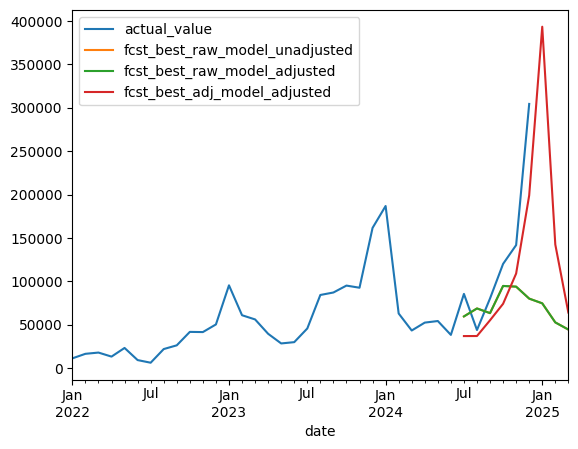

In [162]:
results.groupby('date')[['actual_value', 
                         'fcst_best_raw_model_unadjusted', 
                         'fcst_best_raw_model_adjusted', 
                         'fcst_best_adj_model_adjusted'
                         ]].sum(min_count=1).plot()

In [21]:
results

,date,key,seasonal,hist_range,actual_value,fcst_best_raw_model_unadjusted,fcst_best_raw_model_adjusted,fcst_best_adj_model_adjusted,best_model_raw,best_model_bias_adj,period
0,2022-01-01,Retail_FoodBazaar_Uptown Depot_Frozen Foods_PR...,N,36+,1170.0,NaN,NaN,NaN,TBF,TBF,train
1,2022-01-01,Retail_ValueStore_Harbor Depot_Snacks_PRD0005,Y,25–36,2880.0,NaN,NaN,NaN,RF_default,RF_default,train
2,2022-01-01,Retail_ValueStore_Uptown Depot_Produce_PRD0019,Y,36+,7200.0,NaN,NaN,NaN,LGBM_default,LGBM_default,train
3,2022-02-01,Retail_FoodBazaar_Uptown Depot_Frozen Foods_PR...,N,36+,1035.0,NaN,NaN,NaN,TBF,TBF,train
4,2022-02-01,Retail_ValueStore_Harbor Depot_Snacks_PRD0005,Y,25–36,90.0,NaN,NaN,NaN,RF_default,RF_default,train
...,...,...,...,...,...,...,...,...,...,...,...
146,2025-02-01,Retail_ValueStore_Uptown Depot_Produce_PRD0019,Y,36+,NaN,9617.545740,9617.545740,9617.545740,LGBM_default,LGBM_default,forecasting
147,2025-03-01,Retail_FoodBazaar_Uptown Depot_Frozen Foods_PR...,N,36+,NaN,2250.000000,2250.000000,2250.000000,TBF,TBF,forecasting
148,2025-03-01,Retail_SuperShop_Harbor Depot_Produce_PRD0019,N,25–36,NaN,20562.295405,20562.295405,40185.243932,LGBM_default,LY_trend,forecasting
149,2025-03-01,Retail_ValueStore_Harbor Depot_Snacks_PRD0005,Y,25–36,NaN,11498.850000,11498.850000,11498.850000,RF_default,RF_default,forecasting
